# QRT Data Challenge 2022
Learning linear factors for stock market returns prediction.

## Data Preparation and Visualisation

In [1]:
# imports
import copy
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch import Tensor
import torch.nn as nn
from typing import List, Optional

In [2]:
cwd = os.getcwd()

x_train = pd.read_csv(os.path.join(cwd,'X_train.csv'), index_col=0, sep=',')
x_train.columns.name = 'date'

y_train = pd.read_csv(os.path.join(cwd,'Y_train.csv'), index_col=0, sep=',')
y_train.columns.name = 'date'

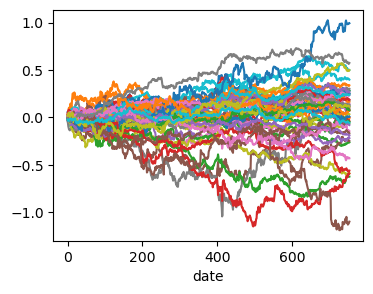

In [3]:
# plot cumulative returns of the 50 stocks from the training data set over the three year period 
x_train.T.cumsum().plot(legend=False, figsize=(4, 3))
plt.show()

It will prove useful to create moving windows from the training data. To this end, we will create
* `x_np` a numpy array with shape $(m,N,D)$
* `y_np` a numpy array with shape $(m,N)$

where 
* $m=504$ - the number of training examples (batch size) 
* $N=50$ - the number of stocks
* $D=250$ - the size of the moving window in days

In [4]:
x_np = x_train.to_numpy().T
x_np = np.stack([np.flip(x_np[i:i+250], axis=0).T for i in range(len(x_np)-250)])
x_np.shape

(504, 50, 250)

In [5]:
x_torch = torch.tensor(x_np)
x_torch.shape

torch.Size([504, 50, 250])

In [6]:
y_np = y_train.to_numpy().T
y_np.shape

(504, 50)

In [7]:
y_torch = torch.tensor(y_np)
y_torch.shape

torch.Size([504, 50])

## Prediction Models

In [8]:
best_metric = {}
best_model = {}

In [9]:
def orthonormalQ_np(A: np.ndarray) -> bool: 
    """Orthonomality checker.
    
    Parameters
    ----------
    A : numpy.ndarray
        matrix of shape (D, F).
    
    Returns
    -------
    bool
        True if the columns of A are orthonormal. False, otherwise.
    """
    F = A.shape[1]  
    error = np.abs(A.T @ A - np.eye(F))
    return (error < 1e-6).all()

In [10]:
def metric_np(y_pred: np.ndarray, y_true: np.ndarray) -> np.float64:
    """Stock returns metric in `numpy`.
    
    Parameters
    ----------
    y_pred : numpy.ndarray
        tensor of predicted stock returns of shape (m, N).
    y_true : numpy.ndarray
        tensor of actual stock returns of shape (m, N).
    
    Returns
    -------
    numpy.float64
        the average normalised inner product bewteen predicted and actual stock returns.
    """
    y_pred = np.divide(y_pred, np.sqrt((y_pred**2).sum(axis=1, keepdims=True)))
    y_true = np.divide(y_true, np.sqrt((y_true**2).sum(axis=1, keepdims=True)))
    return np.einsum('ti,ti->t', y_pred, y_true).mean()

In [11]:
def orthonormalQ_torch(A: Tensor) -> bool: 
    """Orthonomality checker.
    
    Parameters
    ----------
    A : torch.Torch
        matrix of shape (D, F).
    
    Returns
    -------
    bool
        True if the columns of A are orthonormal. False, otherwise.
    """
    F = A.shape[1]  
    error = (torch.matmul(A.T, A) - torch.eye(F)).abs()
    return (error < 1e-6).all().item()

In [12]:
def metric_torch(y_pred: Tensor, y_true) -> np.float64:
    """Stock returns metric in `torch`.
    
    Parameters
    ----------
    y_pred : torch.Tensor
        tensor of predicted stock returns of shape (m, N).
    y_true : torch.Tensor
        tensor of actual stock returns of shape (m, N).
    
    Returns
    -------
    torch.Tensor
        the average normalised inner product bewteen predicted and actual stock returns.
    """
    y_pred = y_pred.div(y_pred.pow(2).sum(keepdim=True, dim=1).sqrt())
    y_true = y_true.div(y_true.pow(2).sum(keepdim=True, dim=1).sqrt())
    return torch.einsum('ti,ti->t', y_pred, y_true).mean()

### 1. Benchmark: Sampling Stiefel Matrices Uniformly At Random

In [13]:
class model_benchmark():
    
    def __init__(self, D: int = 250, F: int = 10) -> None:
        # create beta parameters
        self.beta = np.zeros(F)
        
        # create a random matrix and apply Gram-Schmidt orthonormalisation
        self.A = np.linalg.qr(np.random.randn(D,F))[0]
    
    def factors(self, x: np.ndarray) -> np.ndarray:
        return x @ self.A
    
    def fit(self, x: np.ndarray, y: np.ndarray) -> None:
        factors = self.factors(x)
        self.beta = np.linalg.inv(np.einsum('tia,tib->ab', factors, factors)) @ np.einsum('tib,ti->b', factors, y)
        
    def predict(self, x: np.ndarray) -> np.ndarray:
        return self.factors(x) @ self.beta

In [14]:
number_of_iterations = 1000
best_metric['benchmark'] = -1
best_model['benchmark'] = None

np.random.seed(1234)

for iteration in range(number_of_iterations):
    model = model_benchmark()
    model.fit(x_np, y_np)
    m = metric_np(model.predict(x_np), y_np)
        
    if m > best_metric['benchmark']:
        print(f"[ Iteration: {iteration: 4d} | Metric: {m: 2.5f} ]")
        best_metric['benchmark'] = m
        best_model['benchmark'] = copy.deepcopy(model)
        
print(f"Best metric: {best_metric['benchmark'] : 2.5f}")

[ Iteration:    0 | Metric:  0.02331 ]
[ Iteration:    1 | Metric:  0.03320 ]
[ Iteration:    3 | Metric:  0.03530 ]
[ Iteration:    7 | Metric:  0.04000 ]
[ Iteration:   67 | Metric:  0.04359 ]
[ Iteration:  138 | Metric:  0.04433 ]
[ Iteration:  496 | Metric:  0.04441 ]
[ Iteration:  675 | Metric:  0.04579 ]
Best metric:  0.04579


In [15]:
orthonormalQ_np(best_model['benchmark'].A)

True

### 2. The Exponential Map

In [16]:
class model_exp(nn.Module):
    
    def __init__(self, D: int = 250, F: int = 10) -> None:
        super().__init__()
        # store D and F
        self.D = D
        self.F = F
                
        # create beta parameters
        self.beta = nn.Parameter(torch.randn((F), dtype=torch.float64))
        
        # create weights for generator
        self._weights = nn.Parameter(torch.randn((D*(D-1)//2), dtype=torch.float64))
    
    @property
    def generator(self) -> Tensor:
        ret = torch.zeros((self.D, self.D), dtype=torch.float64)
        ret[torch.triu_indices(self.D, self.D, offset=1).tolist()] = self._weights
        ret = ret - ret.T
        return ret
    
    @property
    def A(self) -> Tensor:
        return torch.matrix_exp(self.generator)[:,:self.F]
    
    def factors(self, x: Tensor) -> Tensor:
        return torch.matmul(x, self.A)
    
    def forward(self, x: Tensor) -> Tensor:
        return torch.matmul(self.factors(x), self.beta)

[ Epoch:   0 | Metric: -0.00934 ]
[ Epoch:  20 | Metric:  0.10129 ]
[ Epoch:  40 | Metric:  0.14312 ]
[ Epoch:  60 | Metric:  0.14797 ]
[ Epoch:  80 | Metric:  0.14887 ]
[ Epoch: 100 | Metric:  0.14905 ]
[ Epoch: 120 | Metric:  0.14908 ]
[ Epoch: 140 | Metric:  0.14909 ]
[ Epoch: 160 | Metric:  0.14909 ]
[ Epoch: 180 | Metric:  0.14909 ]


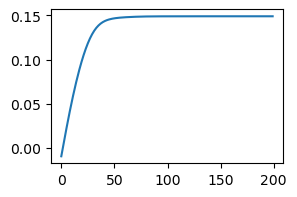

Best metric:  0.14909


In [17]:
number_of_epochs = 200
best_metric['exp'] = -1
best_model['exp'] = None

torch.manual_seed(1234)

model = model_exp()
optimizer = torch.optim.Adam(model.parameters())
model.train(True)

history = []

for epoch in range(number_of_epochs): # loop over the dataset multiple times
    # zero the parameter gradients
    optimizer.zero_grad()
    
    # forward + backward + optimize 
    m = metric_torch(model(x_torch), y_torch)
    loss = -m
    loss.backward()    
    optimizer.step()
    
    m = m.item()
    history.append(m)
    
    if m > best_metric['exp']:
        best_metric['exp'] = m
        best_model['exp'] = model
        best_model['exp'].train(False)
    
    if epoch % 20 == 0:
        print(f"[ Epoch: {epoch:3d} | Metric: {m: 2.5f} ]")

plt.figure(figsize=(3,2))
plt.plot(history)
plt.show()

print(f"Best metric: {best_metric['exp'] : 2.5f}")

In [18]:
orthonormalQ_torch(best_model['exp'].A)

True

### 3. Penalties 

In [19]:
class model_pen(nn.Module):
    
    def __init__(self, D: int = 250, F: int = 10) -> None:
        super().__init__()
        # store F and tolerance
        self.F = F
                
        # create beta parameters
        self.beta = nn.Parameter(torch.randn((F), dtype=torch.float64))
        
        # create a random matrix and apply Gram-Schmidt orthonormalisation
        self.A = nn.Parameter(torch.linalg.qr(torch.randn((D,F), dtype=torch.float64))[0])
    
    def factors(self, x: Tensor) -> Tensor:
        return torch.matmul(x, self.A)
    
    def forward(self, x: Tensor) -> Tensor:
        return torch.matmul(self.factors(x), self.beta)
    
    @property
    def dist(self) -> Tensor:
        "Euclidean distance from constraint surface"
        ret = torch.matmul(self.A.T, self.A) - torch.eye(self.F)
        ret = ret[torch.triu_indices(self.F, self.F).tolist()]
        ret = torch.matmul(ret, ret).sqrt()
        return ret

[ Epoch:    0 | Loss:  0.00154 | Metric: -0.00154 | Dist:  3.17516190]
[ Epoch:  100 | Loss:  0.69031 | Metric:  0.14815 | Dist:  0.46798333]
[ Epoch:  200 | Loss: -0.03959 | Metric:  0.14906 | Dist:  0.54100395]
[ Epoch:  300 | Loss: -0.04174 | Metric:  0.14908 | Dist:  0.15435516]
[ Epoch:  400 | Loss: -0.08299 | Metric:  0.14909 | Dist:  0.03825912]
[ Epoch:  500 | Loss: -0.10919 | Metric:  0.14909 | Dist:  0.00111716]
[ Epoch:  600 | Loss: -0.14692 | Metric:  0.14909 | Dist:  0.01372004]
[ Epoch:  700 | Loss: -0.14784 | Metric:  0.14909 | Dist:  0.00508729]
[ Epoch:  800 | Loss: -0.14821 | Metric:  0.14909 | Dist:  0.00164498]
[ Epoch:  900 | Loss: -0.14890 | Metric:  0.14909 | Dist:  0.00080750]
[ Epoch: 1000 | Loss: -0.14903 | Metric:  0.14909 | Dist:  0.00033795]
[ Epoch: 1100 | Loss: -0.14906 | Metric:  0.14909 | Dist:  0.00012956]
[ Epoch: 1200 | Loss: -0.14908 | Metric:  0.14909 | Dist:  0.00004741]
[ Epoch: 1300 | Loss: -0.14909 | Metric:  0.14909 | Dist:  0.00002176]
[ Epoc

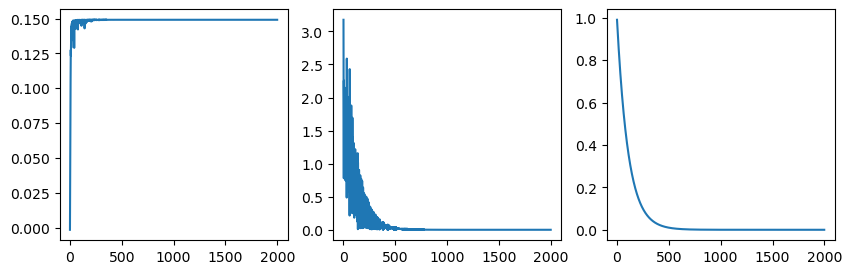

Best metric:  0.14909


In [25]:
number_of_epochs = int(2e3)
best_metric['pen'] = -1
best_model['pen'] = None

torch.manual_seed(1234)

model = model_pen()
lr_initial = 1
lr_final = 1e-8
rate = (lr_final/lr_initial)**(1/number_of_epochs)
optimizer = torch.optim.SGD(model.parameters(), lr=lr_initial)
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer, 
    lr_lambda = lambda epoch: rate**epoch, 
    last_epoch = -1
)

model.train(True)

history = {"metric":[], "dist":[], "lr":[]}

for epoch in range(number_of_epochs): # loop over the dataset multiple times
    # zero the parameter gradients
    optimizer.zero_grad()
    
    # forward + backward + optimize 
    m = metric_torch(model(x_torch), y_torch)
    loss = - m + model.dist
    loss.backward()    
    optimizer.step()
    scheduler.step()
    
    m = m.item()
    d = model.dist.item()
    
    history["metric"].append(m)
    history["dist"].append(d)
    history["lr"].append(optimizer.param_groups[0]["lr"])
    
    if epoch % 100 == 0:
        print(f"[ Epoch: {epoch:4d} | Loss: {loss.item(): 3.5f} | Metric: {m: 2.5f} | Dist: {d: 2.8f}]")
    
    if orthonormalQ_torch(model.A) and m > best_metric['pen']:
        best_metric['pen'] = m
        best_model['pen'] = copy.deepcopy(model)
        best_model['pen'].train(False)   
        
plt.figure(figsize=(10,3))
plt.subplot(1, 3, 1)
plt.plot(history["metric"])
plt.subplot(1, 3, 2)
plt.plot(history["dist"])
plt.subplot(1, 3, 3)
plt.plot(history["lr"])
plt.show()

print(f"Best metric: {best_metric['pen'] : 2.5f}")

In [26]:
orthonormalQ_torch(best_model['pen'].A)

True